In [ ]:
from google.colab import files


uploaded = files.upload()

Saving mLabel_tweets.csv to mLabel_tweets.csv


In [ ]:
import pandas as pd
import io
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from os import wait4
from numpy import log10
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn import svm
import numpy as np



nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word): #returns the proper tag for part of speech
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import re
#get and clean data

# retrieve
df = pd.read_csv(io.BytesIO(uploaded['mLabel_tweets.csv']))
data = df.to_numpy()
XRaw = data[:, 1] #X is one row, each entry is just the tweet.
YRaw = data[:, -1] #output

X = [];
Y = [];

#clean X
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range(len(XRaw)):
  #remove stop words
  cur_text = re.sub(r'[^\w]', ' ', XRaw[i])
  #convert to list of words
  tempTxt = word_tokenize(cur_text);
  #filteredTxt is where we'll be putting out filtered sentance.
  filteredTxt = "";


  for w in tempTxt: #for each word
    w = w.lower(); # convert to lower case
    if w not in ['.', ',', '!', '?']: # if word is not a punctuation. Potentially add '' and "" as well
      if w not in stop_words or w in ['no', 'not']: # if word is not a stop word
      #"no" and "not" are stop words, but could be important for setiment analysis. Possibly remove that section
        lemma_w = lemmatizer.lemmatize(w, get_wordnet_pos(w));
        #now add it to the sentance
        if filteredTxt != "": #if the filtered text is not empty.
          if filteredTxt[-1] != '@': #and the last character is not an at symbol
            if filteredTxt[-1] != '#': #and the last character is not a hashtag
              filteredTxt += " "; #add a space between words

        filteredTxt += lemma_w #add to the new sentence

  # add final result to the clean data array
  X.append(filteredTxt)

#clean Y
#since the none label does not require prediction (it's simply if nothing else is chosen), it is not included in out Y.
binaryVectorKey = ["unnecessary", "mandatory", "pharma", "conspiracy", "political", "country", "rushed", "ingredients", "side-effect", "ineffective", "religious"]

for i in range (len(YRaw)):
  #convert to binary output vector
  result = [0] * len(binaryVectorKey)

  for j in range(len(binaryVectorKey)):
    if binaryVectorKey[j] in YRaw[i]: #if term appears in our rawY, mark the proper output position as true
      result[j] = 1

  Y.append(result)

Y = np.array(Y)

In [ ]:
# evaluate any model
from sklearn.base import clone
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def acc(preds,y) :
  cnt = 0
  for i in range(len(preds)) :
    if preds[i] == y[i] :
      cnt += 1
  return cnt / len(preds)

def evaluate_model(name,model, X_trainVectorized, X_testVectorized,Y_train,Y_test,score=f1_score) :

  #print("Size of y_train.shape[1]: {}".format((Y_train.shape[1]))) #about 9000
  clfSet = []
  for i in range(Y_train.shape[1]): #create a classifier for each of the labels
    clf = clone(model)
    clf = clf.fit(X_trainVectorized, Y_train[:, i])
    clfSet.append(clf)

  #evaluate the macro score and add the average to our train and test f1 scores
  train_score = evaluate_score(name, clfSet, X_trainVectorized, Y_train, score=score)
  test_score = evaluate_score(name, clfSet, X_testVectorized, Y_test,plot_data=True, score=score)

  #evaluate the macro score and add the average to our train and test scores, using accuracy score
  acc_train_score = evaluate_score(name, clfSet, X_trainVectorized, Y_train, score=acc)
  acc_test_score = evaluate_score(name, clfSet, X_testVectorized, Y_test, score=acc)

  return acc_test_score, test_score

Above this is data processing and functions that are used by all potential classifiers.
Below this, each code block is an option on classifer.
Delete this block and unsed classifiers once we decide what is best.

In [ ]:
#new evaluation function
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

# evaluate and return score, can also plot
def evaluate_score(name, classifiers, X, Y,plot_data=False,score=f1_score):
  #done in terms of macro-average score
  cur_scores= []

  # go through each classifier
  for i in range(len(classifiers)) :
    # get predictions
    predictions = classifiers[i].predict(X)

    # save score based on given metric
    cur_scores.append(score(Y[:, i], predictions))

  # ability to bar plot each class
  if plot_data :
    # x = class names, y = scores
    plt.bar(binaryVectorKey, cur_scores,color='blue',width=0.2)

    # labels, title
    plt.xlabel("Classes")
    plt.ylabel("Score")
    plt.title(f"{name} Performance Across All Classes")

    # show
    plt.show()

  # return avg accuracy
  return np.average(cur_scores)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, hstack

# generate types of data
def generate_data(X, Y, i) :
  # split data
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = i * 1000)

  # create data dict
  data = {}
  data['count'] = []
  data['tfidf'] = []

  # go through each min_df (currently best is selected)
  for min_df in [3] :
    # go through each ngram (currently best is selected)
    for ngram_range in [(1,2)] :

      # create both vectorizers
      count_vectorizer = CountVectorizer(min_df = min_df, max_df = 0.8, ngram_range = ngram_range)
      vectorizer = TfidfVectorizer(min_df = min_df, max_df = 0.8, sublinear_tf = True, use_idf = True, ngram_range =ngram_range)

      #convert train X to a matrix of tf-idf/count scores. Vectorizer learns vocab and idf
      X_trainVectorized = vectorizer.fit_transform(X_train)
      X_trainVectorized_count = count_vectorizer.fit_transform(X_train)
      #convert test X to a matrix of tf-idf/count scores. Vectorizer does not learn
      X_testVectorized = vectorizer.transform(X_test)
      X_testVectorized_count = count_vectorizer.transform(X_test)

      # add vectorized data to list of permutations
      data['count'] += [(X_trainVectorized_count, X_testVectorized_count)]
      data['tfidf'] += [(X_trainVectorized, X_testVectorized)]

  return data, Y_train, Y_test

In [ ]:
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils

def make_lda(X) :
  # Assuming 'documents' is a list of preprocessed sentences
  documents = X

  # Tokenize the documents and create a dictionary
  tokenized_documents = [document.split() for document in documents]
  dictionary = corpora.Dictionary(tokenized_documents)

  # Convert tokenized documents to a bag of words (BoW) representation
  corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

  # Train the LDA model
  lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

  # Get LDA features for each document
  lda_features = lda_model[corpus]

  # Extract the LDA features into a matrix
  lda_matrix = matutils.corpus2dense(lda_features, num_terms=lda_model.num_topics).T

  return lda_matrix

In [ ]:
# generate data
data, Y_train, Y_test = generate_data(X, Y, 0)


name, class balance (# positive / total)
unnecessary:
class balance: 0.07277492188287471
mandatory:
class balance: 0.07892349561536136
pharma:
class balance: 0.1283136780566475
conspiracy:
class balance: 0.04908779356919665
political:
class balance: 0.06309847797601048
country:
class balance: 0.020260054429996975
rushed:
class balance: 0.1487753250680375
ingredients:
class balance: 0.04394718274367503
side-effect:
class balance: 0.3835298861001915
ineffective:
class balance: 0.16853139804455197
religious:
class balance: 0.0064509626045761515
['unnecessary', 'mandatory', 'pharma', 'conspiracy', 'political', 'country', 'rushed', 'ingredients', 'side-effect', 'ineffective', 'religious']


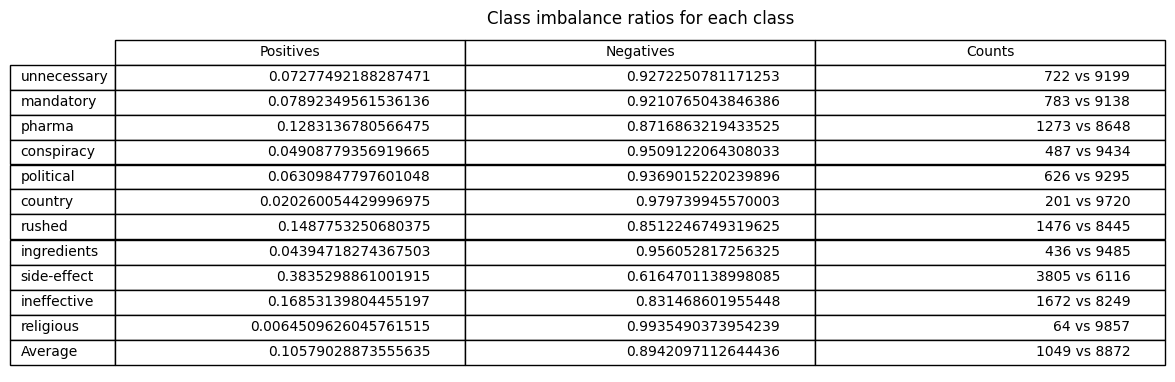

In [ ]:
Y_cur = np.array(Y)

# class imbalance + count lists
imbalances = []
counts = []

# text used for table
cell_text = [[], [], []]
for i in range(Y_cur.shape[1]) :
  # gets Y values for class, and how many positive occurances
  vals = Y_cur[:, i]
  ones = np.count_nonzero(vals == 1)

  # gets imbalance ratio, count
  imbalances.append(ones / Y_cur.shape[0])
  counts.append(ones)

  # append text [ones ration, zeros ratio, count]
  cell_text[0].append(ones / Y_cur.shape[0])
  cell_text[1].append(1 - (ones / Y_cur.shape[0]))
  cell_text[2].append(f"{ones} vs {Y_cur.shape[0] - ones}")

# append averages
cell_text[0].append(np.average(imbalances))
cell_text[1].append(1 - np.average(imbalances))
cell_text[2].append(f"{int(np.average(counts))} vs {Y_cur.shape[0] - int(np.average(counts))}")

# plot table
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(left=0.2, bottom=0.2)

# set up table
table = plt.table(cellText=np.transpose(cell_text),
                  rowLabels=binaryVectorKey + ["Average"],
                  colLabels=["Positives", "Negatives", "Counts"],
                  loc='center')

plt.title(f"Class imbalance ratios for each class")
table.scale(1, 1.5)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


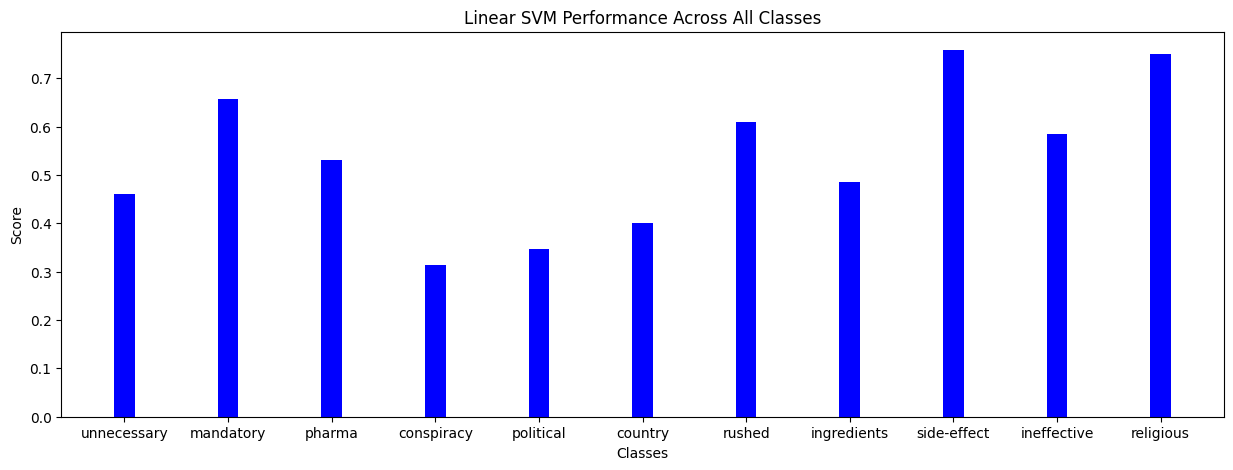

Name : Linear SVM 1 Score: 0.5360064648847821, 0.9238836730020611


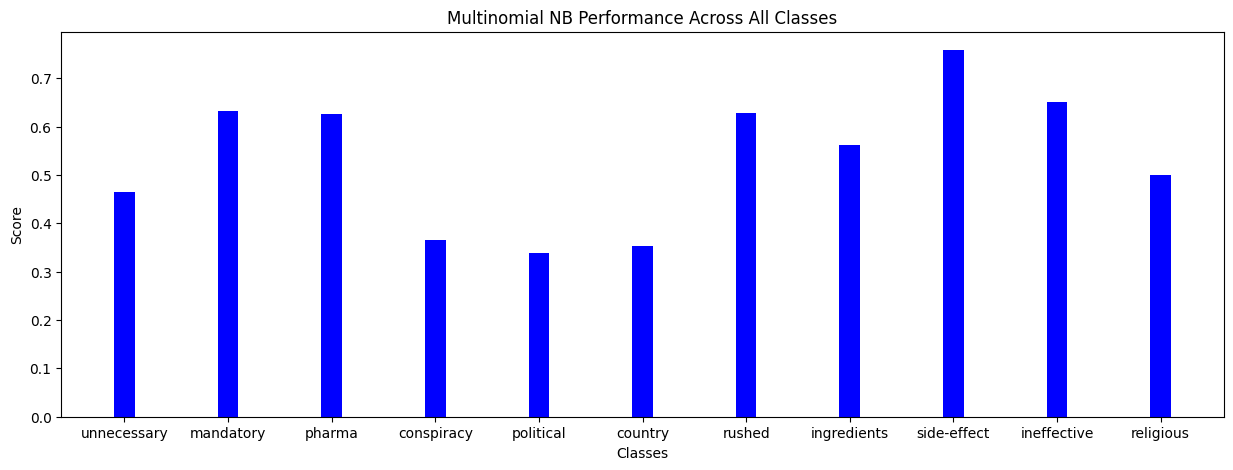

Name : Multinomial NB 1 Score: 0.5345582483254238, 0.9223723379894665


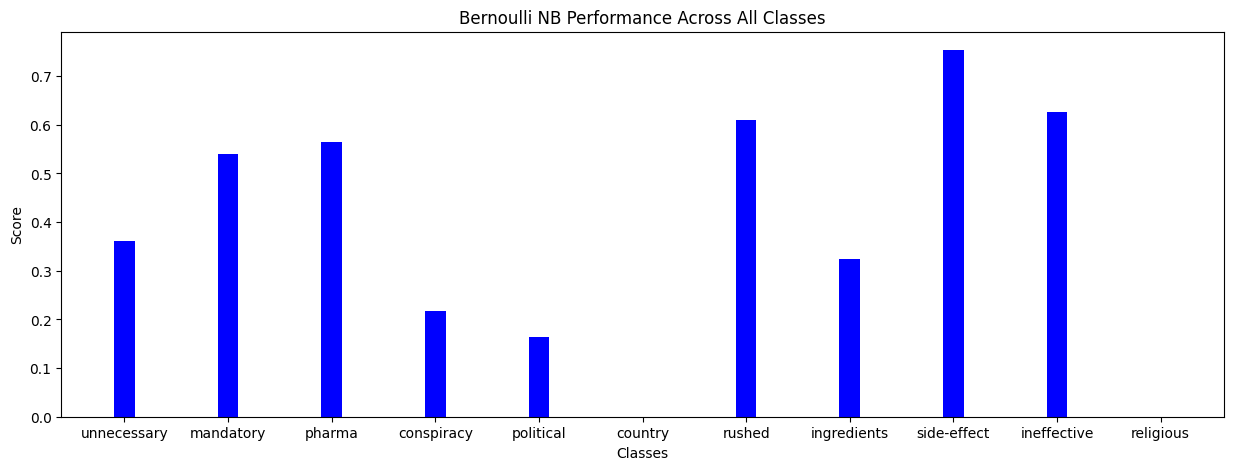

Name : Bernoulli NB 1 Score: 0.37808042082915455, 0.9295626288069613


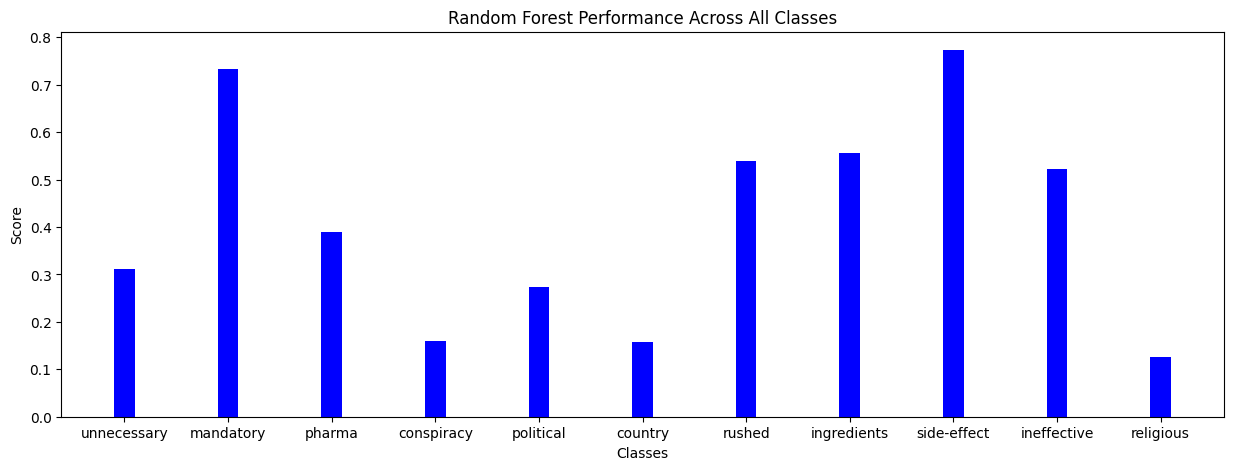

Name : Random Forest 1 Score: 0.4126733151264148, 0.932768490954889


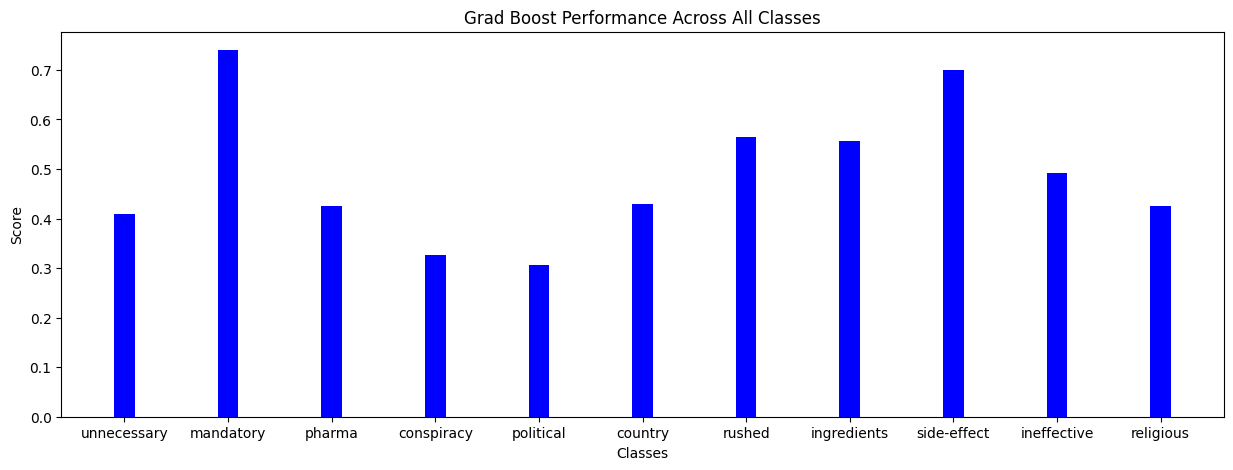

Name : Grad Boost 1 Score: 0.4880168132440048, 0.9296084268376461


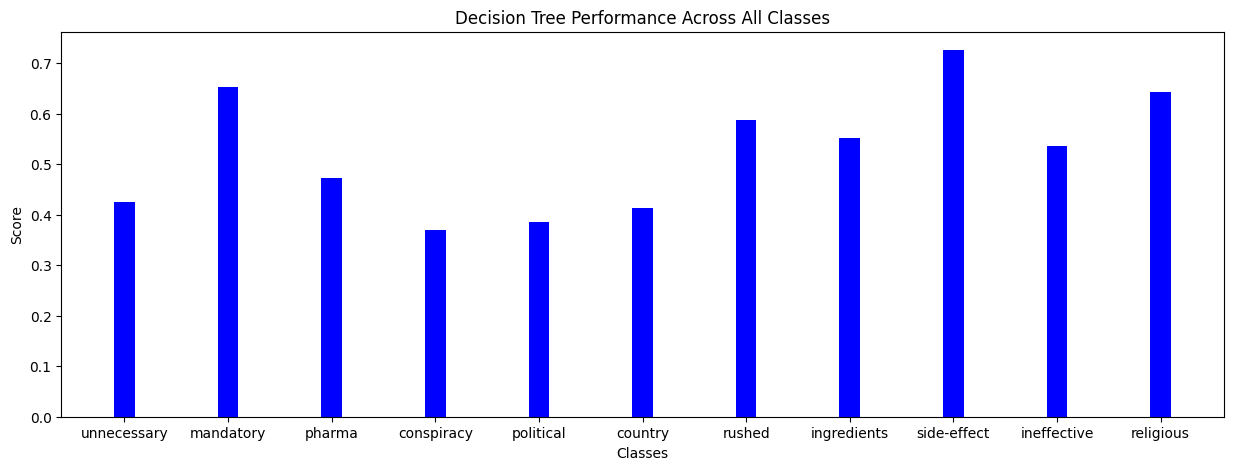

Name : Decision Tree 1 Score: 0.5238082784056582, 0.9169223723379895


KeyboardInterrupt: ignored

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

models = {}
n_evaluations = 1

# add model to dict
def add_model(name, model) :
  if models.get(name) == None :
    models[name] = []
  models[name].append(model)

# adds all wanted model to dict
add_model("Linear SVM", svm.LinearSVC(C = 1.2, loss = 'hinge', class_weight = 'balanced'))
add_model("Multinomial NB", MultinomialNB(alpha = .4, force_alpha = True, fit_prior = True))
add_model("Bernoulli NB", BernoulliNB(alpha = .8, force_alpha = True, fit_prior = True))
add_model("Random Forest", RandomForestClassifier(n_estimators=150))
add_model("Grad Boost", GradientBoostingClassifier())

add_model("Decision Tree", DecisionTreeClassifier())
add_model("XGB", XGBClassifier())

#add_model("NN", MLPClassifier(hidden_layer_sizes=(10,10),activation="tanh",learning_rate="adaptive"))
#add_model("NN", MLPClassifier(hidden_layer_sizes=(10,40,20),activation="relu",learning_rate="adaptive",max_iter=1000, epsilon=1e-10))
#add_model("KNN", KNeighborsClassifier(n_neighbors=25))

best_type = ""
best_index = 0
best_test = 0
best_data = ""

# go through each type of data
for name, cur_data in data.items() :
    # go through each permutation of vectorizer
    for data_index, (X_train, X_test) in enumerate(cur_data) :
      scores = {}

      # go through each model type
      for model_type in models.keys() :
        # go through each model hyperparam
        for (i, model) in enumerate(models[model_type]) :
          # get scores
          acc_score, test_score = evaluate_model(model_type, model, X_train, X_test, Y_train, Y_test)
          print(f"Name : {model_type} {i+1} Score: {test_score}, {acc_score}")

          # save best model
          scores[model_type] = (acc_score, test_score)
          if test_score > best_test :
            best_type = model_type
            best_index = i
            best_test = test_score
            best_data = (name, data_index)

      # get score text
      cell_text = []
      for k, v in scores.items() :
        # save accuracy, score
        cell_text.append([v[0], v[1]])

      # plot table
      ax = plt.gca()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.box(on=None)
      plt.subplots_adjust(left=0.2, bottom=0.2)

      # set up table
      table = plt.table(cellText=cell_text,
                      rowLabels=list(scores.keys()),
                      colLabels=["Accuracy", "F1"],
                      loc='center')
      plt.title(f"Accuracy Scores Across Models for {name} data")
      table.scale(1, 1.5)
      plt.show()


print(f"best model {best_type}{best_index}, best data/index: {best_data}, best score: {best_test}")